In [6]:
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz

from keras.layers.core import Lambda
from keras import backend as K

def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)
    
    return BatchInd,NumBatches

import win32clipboard as clipboard
def toClipboardForExcel(array):
    """
    Copies an array into a string format acceptable by Exce~l.
    Columns separated by \t, rows separated by \n
    """
    # Create string from array
    line_strings = []
    for line in array:
        line_strings.append("\t".join(line.astype(str)).replace("\n",""))
    array_string = "\r\n".join(line_strings)

    # Put string into clipboard (open, clear, set, close)
    clipboard.OpenClipboard()
    clipboard.EmptyClipboard()
    clipboard.SetClipboardText(array_string)
    clipboard.CloseClipboard()
    
    
def Get_Feats_and_Targets(filename):
    import numpy as np
    
    def line_to_Feats(line):
        line = line.split(sep= ' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)
        
    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

In [7]:
[TrainInputs,TrainTargets] = Get_Feats_and_Targets('C:\Active Learning Work\GeoShapes\shapeset\shapeset1_1cspo_2_3.10000.train.amat')

[ValInputs,ValTargets] = Get_Feats_and_Targets('C:\Active Learning Work\GeoShapes\shapeset\shapeset1_1cspo_2_3.5000.valid.amat')

In [9]:
data_dim = TrainInputs.shape[-1]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0.0005

Hard_model = Sequential()
Hard_model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
Hard_model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
Hard_optim = optimizers.adagrad(lr=0.001)
Hard_model.compile(loss='categorical_crossentropy',optimizer=Hard_optim,metrics=['categorical_accuracy'])

Easy_model = Sequential()
Easy_model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
Easy_model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
Easy_optim =  optimizers.adagrad(lr=0.001)
Easy_model.compile(loss='categorical_crossentropy',optimizer=Easy_optim,metrics=['categorical_accuracy'])

UniHard_model = Sequential()
UniHard_model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
UniHard_model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
UniHard_optim = optimizers.adagrad(lr=0.001)
UniHard_model.compile(loss='categorical_crossentropy',optimizer=UniHard_optim,metrics=['categorical_accuracy'])

UniEasy_model = Sequential()
UniEasy_model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
UniEasy_model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
UniEasy_optim =  optimizers.adagrad(lr=0.001)
UniEasy_model.compile(loss='categorical_crossentropy',optimizer=UniEasy_optim,metrics=['categorical_accuracy'])

ISHard_model = Sequential()
ISHard_model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
ISHard_model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
ISHard_optim = optimizers.adagrad(lr=0.001)
ISHard_model.compile(loss='categorical_crossentropy',optimizer=ISHard_optim,metrics=['categorical_accuracy'])

ISEasy_model = Sequential()
ISEasy_model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
ISEasy_model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
ISEasy_optim =  optimizers.adagrad(lr=0.001)
ISEasy_model.compile(loss='categorical_crossentropy',optimizer=ISEasy_optim,metrics=['categorical_accuracy'])

Uni_model = Sequential()
Uni_model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
Uni_model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
Uni_Optim =  optimizers.adagrad(lr=0.001)
Uni_model.compile(loss='categorical_crossentropy',optimizer=Uni_Optim,metrics=['categorical_accuracy'])



Test_model = Sequential()
Test_model.add(Lambda(lambda x: K.dropout(x, level=0.05),input_shape =(data_dim,)))
Test_model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
Test_model.add(Lambda(lambda x: K.dropout(x, level=0.05)))
Test_model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
Test_Optim =  optimizers.adagrad(lr=0.001)
Test_model.compile(loss='binary_crossentropy',optimizer=Test_Optim,metrics=['accuracy'])


In [11]:
Pred = Hard_model.predict(TrainInputs)
toClipboardForExcel(Pred)

In [12]:
def acquisition_function_dist_to_threshold(model,samples,Num_Targets,Smoothing_Const=0):
    Output = model.predict(samples)
    Output -= 1/Num_Targets
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold) + Smoothing_Const
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold)
    return Sampling_Prob


def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        Model_Output = Model.predict(Inputs)
        ClassProb = Model_Output[:,TargetLoop]
        Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
        ExpChange += Loss*ClassProb
    return ExpChange

def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = Exp_ModelChange(model,samples,Num_Targets) + Smoothing_Const
    Sampling_Prob = ExpChange/np.sum(ExpChange)
    if Rescale == 1:
        Median_Prob = np.median(Sampling_Prob)
        Min_Prob = np.min(Sampling_Prob)
        Sampling_Prob[Sampling_Prob > Median_Prob] += Min_Prob/2
        Sampling_Prob[Sampling_Prob < Median_Prob] -= Min_Prob/2
    return Sampling_Prob

def Get_L2_Loss(Model,Coeff=0.01):
    Reg_Loss = 0
    Weights = Model.get_weights()
    NumWeights = len(Weights)
    for i in range(NumWeights):
        LayerWeights = Weights[i]
        LayerWeights_Sq = LayerWeights**2
        Reg_Loss += LayerWeights_Sq.sum()
    Reg_Loss*=Coeff
    return Reg_Loss


def acquisition_function_exp_model_change(model,samples,Num_Targets,Smoothing_Const=0,Rescale=0):
    ExpChange = Exp_ModelChange(model,samples,Num_Targets) + Smoothing_Const
    ExpChange = ExpChange/np.sum(ExpChange)
    
    if Rescale == 1:
        Median_Prob = np.median(ExpChange)
        Min_Prob = np.min(ExpChange)
        ExpChange[ExpChange > Median_Prob] += Min_Prob/2
        ExpChange[ExpChange < Median_Prob] -= Min_Prob/2
    return ExpChange


def ablate_network(model,ablation_perc):
    weights = model.get_weights()
    save_weights = weights.copy()
    NumLayers = len(weights)
    total_numweights  = 0 
    for i in range(NumLayers):
        layer = weights[i]
        total_numweights += len(layer.flatten())
    num_ablations = np.int(ablation_perc*total_numweights)
    weights = ablate_weights(weights,num_ablations)
    model.set_weights(weights)
        
    return(model,save_weights)


def ablation_curve(model,num_tests,max_perc,inputs,targets):
    Perc_Space = np.linspace(0,max_perc,num_tests)
    Performance = np.zeros(num_tests)
    for i in range(num_tests):
        model,save_weights = ablate_network(model,Perc_Space[i])
        Perf = model.test_on_batch(inputs,targets)
        Performance[i] = Perf[1]
        model.set_weights(save_weights)
        
        AUC = trapz(Performance,Perc_Space)
        
    return AUC,Performance
    
    
def ablate_weights(weights,num_ablations):
    NumLayers = len(weights)
    LayerShape = []
    LayerShape = []
    LayerNodes = [0]
    FlattenedNodes = np.empty([0])
    for i in range(NumLayers):
        LayerShape.append(weights[i].shape)
        LayerNodes.append(len(weights[i].flatten()))
        FlattenedNodes = np.append(FlattenedNodes,weights[i].flatten())
        Index = np.linspace(0,len(FlattenedNodes)-1,num=len(FlattenedNodes),dtype = int)
    RandChoice = np.random.choice(Index,size = num_ablations,replace=False)
    FlattenedNodes[RandChoice] = 0
    FirstInd = 0
    for i in range(NumLayers):
        FirstInd += LayerNodes[i]
        SecondInd = FirstInd + LayerNodes[i+1]
        Sample = FlattenedNodes[FirstInd:SecondInd]
        Sample = Sample.reshape(LayerShape[i])
        weights[i] = Sample
        
    return weights


def acquisition_function_ablation(model,Inputs,Targets,Cluster_Size):
    BatchInd,NumBatches = mini_batches(Inputs,Cluster_Size)
    AUC_Record = np.zeros([Inputs.shape[0]])
    count= 0
    for Batch in BatchInd:
        if Batch.shape[0] != 0:
            BatchInputs = Inputs[Batch,:]
            BatchTargets = Targets[Batch,:]
            SaveWeights = model.get_weights()
            Hard_model.fit(BatchInputs,BatchTargets,batch_size=64,verbose=0)
            AUC,_ = ablation_curve(model,30,1,Inputs,Targets)
            AUC_Record[Batch] = AUC.copy()
            Hard_model.set_weights(SaveWeights)
            count +=1
        
    Sampling_Prob = AUC_Record/AUC_Record.sum()
    return Sampling_Prob
    
    


In [14]:
count = 0 
Num_Epochs = 300
Num_BurnIn = 1
Batch_Size = 64

Smoothing_Constant = 0

<IPython.core.display.Javascript object>


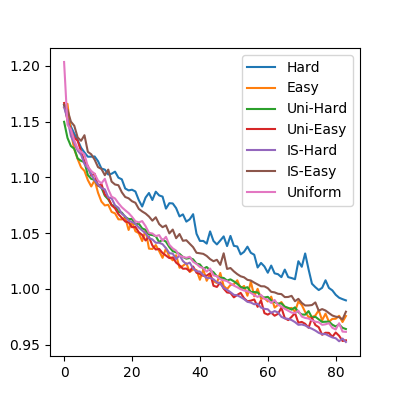

<IPython.core.display.Javascript object>


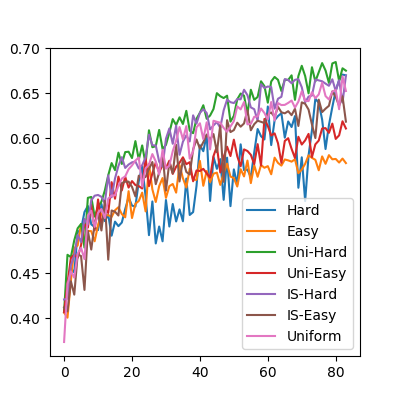

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


In [ ]:
Val_Error = np.zeros([Num_Epochs,7])
Val_Acc = np.zeros([Num_Epochs,7])

fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()


def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
            
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
        Hard_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = Hard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Easy_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = Easy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        UniHard_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
        
        UniEasy_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]
        
        ISHard_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,4] = Error[0]
        Val_Acc[count,4] = Error[1]
        
        ISEasy_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,5] = Error[0]
        Val_Acc[count,5] = Error[1]
        
        Uni_model.fit(TrainInputs,TrainTargets,batch_size = 32,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,6] = Error[0]
        Val_Acc[count,6] = Error[1]
    else:
        Sampling_Probability = acquisition_function_exp_model_change(Hard_model,TrainInputs,Num_Targets,0,1)
        Inverse_SamplingProbability = 1/acquisition_function_exp_model_change(Easy_model,TrainInputs,Num_Targets,0,1)
        Inverse_SamplingProbability = Inverse_SamplingProbability/Inverse_SamplingProbability.sum()
        
        ISSampling_Probability = acquisition_function_exp_model_change(ISHard_model,TrainInputs,Num_Targets,0,1)
        ISInverse_SamplingProbability = 1/acquisition_function_exp_model_change(ISEasy_model,TrainInputs,Num_Targets,0,1)
        ISInverse_SamplingProbability = ISInverse_SamplingProbability/ISInverse_SamplingProbability.sum()
        
        UniSampling_Probability = acquisition_function_exp_model_change(ISHard_model,TrainInputs,Num_Targets,0,1)
        UniInverse_SamplingProbability = 1/acquisition_function_exp_model_change(UniEasy_model,TrainInputs,Num_Targets,0,1)
        UniInverse_SamplingProbability = UniInverse_SamplingProbability/UniInverse_SamplingProbability.sum()
    
#         Anneal_Power = -(2*EpochLoop/Num_Epochs -1)
#         Anneal_SamplingProbability = acquisition_function(Anneal_model,TrainInputs,Num_Targets,Smoothing_Constant)**Anneal_Power
#         Anneal_SamplingProbability = Anneal_SamplingProbability/Anneal_SamplingProbability.sum()
        
        Hard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Sampling_Probability,-1),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        Easy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Inverse_SamplingProbability,-1),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        UniHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,UniSampling_Probability,0),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        UniEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,UniInverse_SamplingProbability,0),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        ISHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,ISSampling_Probability,1),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        ISEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,ISInverse_SamplingProbability,1),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/NumSamples*np.ones(NumSamples)),
                                steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        Error = Hard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = Easy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        Error = UniHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
        
        Error = UniEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]
        
        Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,4] = Error[0]
        Val_Acc[count,4] = Error[1]
        
        Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,5] = Error[0]
        Val_Acc[count,5] = Error[1]
        
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,6] = Error[0]
        Val_Acc[count,6] = Error[1]
        
#         for BatchLoop in range(np.int(NumSamples/Batch_Size)):
#             Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
#             Batch_Input = TrainInputs[Batch,:]
#             Batch_Target = TrainTargets[Batch,:]
#             Batch_Weights = Weights[Batch]
#             model.fit(Batch_Input,Batch_Target,epochs=1,validation_data=[ValInputs,ValTargets],verbose=1,sample_weight = Batch_Weights)
#             model.train_on_batch(Batch_Input,Batch_Target,sample_weight = Batch_Weights)
#         Error = model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[EpochLoop,0] = Error[0]
            
#         Batch2 = np.random.choice(index,size=Batch_Size,replace=False)
#         Batch_Input2= TrainInputs[Batch2,:]
#         Batch_Target2 = TrainTargets[Batch2,:]
# #             model2.fit(Batch_Input2,Batch_Target2,epochs=1,validation_data=[ValInputs,ValTargets],verbose=1)
#         model2.train_on_batch(Batch_Input2,Batch_Target2)
#         Error = model2.test_on_batch(ValInputs,ValTargets)
#         Val_Error[EpochLoop,1] = Error[0]
            
#             print(BatchLoop)
#             print(np.int(NumSamples/Batch_Size))
            
    print(EpochLoop)
    
    ax.clear()
    ax.plot(Val_Error[0:count,0],label='Hard')
    ax.plot(Val_Error[0:count,1],label='Easy')
    ax.plot(Val_Error[0:count,2],label='Uni-Hard')
    ax.plot(Val_Error[0:count,3],label='Uni-Easy')
    ax.plot(Val_Error[0:count,4],label='IS-Hard')
    ax.plot(Val_Error[0:count,5],label='IS-Easy')
    ax.plot(Val_Error[0:count,6],label='Uniform')
    ax.legend()
    fig.canvas.draw()
    
    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='Hard')
    ax2.plot(Val_Acc[0:count,1],label='Easy')
    ax2.plot(Val_Acc[0:count,2],label='Uni-Hard')
    ax2.plot(Val_Acc[0:count,3],label='Uni-Easy')
    ax2.plot(Val_Acc[0:count,4],label='IS-Hard')
    ax2.plot(Val_Acc[0:count,5],label='IS-Easy')
    ax2.plot(Val_Acc[0:count,6],label='Uniform')
    ax2.legend()
    fig2.canvas.draw()
    
    count += 1

In [9]:
[ValInputs,ValTargets] = Get_Feats_and_Targets('C:\Active Learning Work\GeoShapes\shapeset\shapeset1_1cspo_2_3.5000.test.amat')

In [10]:
TestError = np.zeros([7,2])
TestError[0,:] = Hard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = Easy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = UniHard_model.test_on_batch(TestInputs,TestTargets)
TestError[3,:] = UniEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[4,:] = ISHard_model.test_on_batch(TestInputs,TestTargets)
TestError[5,:] = ISEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[6,:] = Uni_model.test_on_batch(TestInputs,TestTargets)

In [11]:
toClipboardForExcel(TestError)

In [12]:
def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        Model_Output = Model.predict(Inputs)
        ClassProb = Model_Output[0,TargetLoop]
        for i in range(Inputs.shape[0]):
            thisInput = Inputs[i,:]
            thisInput = thisInput.reshape([1,thisInput.shape[0]])
            thisTargetNow = thisTarget[i,:]
            thisTargetNow = thisTargetNow.reshape([1,Num_Targets])
            Error = Model.test_on_batch(thisInput,thisTargetNow)
            ExpChange[i] += Error[0]*ClassProb
            
    return ExpChange
    
        

In [13]:
Test = Exp_ModelChange(Hard_model,ValInputs,Num_Targets)

In [8]:
def get_Sample_Error(i,Inputs,Target):
    InputSample = Inputs[i,:]
    InputSample = InputSample.reshape([1,InputSample.shape[0]])
#     Error = Model.test_on_batch(InputSample,Target)
    Error = 0
    return(Error)
    

In [35]:
[a,b,c] = Hard_model.test_on_batch(TrainInputs,TrainTargets)

In [36]:
c

0.10000017